In [ ]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import pandas as pd
import zipfile
import io
import math

def css_styling():
    styles = open('../notebook_styles.css', 'r').read()
    return HTML(styles)
css_styling()

In [ ]:
#Loading testing data
from client.api.notebook import Notebook 
lab05 = Notebook('lab05.ok')
_ = lab05.auth(inline=True)

# Lab 05 - Projections and a first look at formal demography

Today we're going to be taking a look at *formal demography* -- the mathematical theory of relationships that govern population structure and change.  In a course devoted to demographic methods, you would learn about these relationships mathematically.  Today, we're going to adopt a more experimental approach: I'll provide you with some tools that you can use to explore how populations change over time and you can see for yourself what kind of patterns emerge. By looking at population projections, we'll see some illustrations of formal demography in action.

We'll touch on a few key concepts over the course of the day:

* age distributions - what is the age-composition of a population? How does this seem to change over time?
* projections - if we assume that fertility and mortality rates don't change, we can predict how the population will change over time
* stability - if fertility and mortality rates hold steady for a long time, does the population settle down?

Here are a few things to bear in mind as we explore;

* we'll use simulation in place of math, but if you are curious about how this all works, there is a lot of theory underlying the relationships we'll look at today
* we'll focus on a female-only populations, to keep things fairly simple
* in a couple of cases, we're simplifying things a little bit. So the results we'll calculate today won't be quite as accurate as projections produced by the UN or the Census Bureau. But we'll get the big picture ideas right


## Introductions

**What is your partner's name?**

[ANSWER HERE]

**What is your partner's hometown?**

[ANSWER HERE]

**What is your partner's favorite food?**

[ANSWER HERE]

## Projections: combining mortality and fertility

Today, we're going to work with several different types of data:

* life tables - which have information about mortality
* fertility rates - which tell us about reproduction
* population counts - which tell us about age distributions

We'll start by opening these datasets up.

First we'll open up the UNPD life tables

In [ ]:
unpd_lt = Table.read_table('../data/UNPD/unpd_life_tables_cleaned.csv')
unpd_lt

This function will help us read life tables in as we need them. You can see how it's used below.

In [ ]:
def get_lt(country, period, sex='female'):
    """
    This function reads in the life table data for a given country and time period.
    """
    lt_data = unpd_lt.where('area', country).where('period', period).where('sex', sex)
    return(lt_data.sort('age'))

get_lt('France', 2010, 'female').show()

Next, we'll read in age-specific fertility data

In [ ]:
unpd_asfr = Table.read_table('../data/UNPD/unpd_asfr_cleaned.csv')
unpd_asfr

This function will help us read in the age-specific fertility rates for a given country and time period.  You can see how it's used below.

In [ ]:
def get_asfr(country, period):
    asfr_data = unpd_asfr.where('area', country).where('period', period)
    # rescale rates (which are listed per 1,000 in the UNPD data)
    asfr_data = asfr_data.with_column('asfr', asfr_data['asfr']/1000)
    return(asfr_data.sort('age'))

get_asfr('France', 2010)

Finally, we'll open up a dataset with estimated female population counts by age and time period:

In [ ]:
unpd_pop = Table.read_table('../data/UNPD/unpd_f_pop_byage_cleaned.csv')
unpd_pop

... and this function will help us read in the female population distributions by age for a given country and time period.  You can see how it's used below.

In [ ]:
def get_pop(country, reference_date):
    raw_dat = unpd_pop.where('area', country).where('reference_date', reference_date)
    return(raw_dat)

get_pop('France', 2015).show()

Here's one last helper function that will save us some time later. It gives us an `np.array` that has the number of women by age in a given country and year. We'll see that sometimes this is more useful than having a table.

In [ ]:
def get_pop_vec(country, reference_date):
    dat = get_pop(country, reference_date)
    
    # collapse last two age groups to get 75+ to match our Leslie matrices
    #pop_vec = dat.column('f_population')[:-2]
    #pop_vec = np.append(pop_vec, np.sum(dat.column('f_population')[-2:]))
    pop_vec = dat.column('f_population')
    
    return(pop_vec)

get_pop_vec('France', 2015)

It will also be helpful here and there to have a list of all of the possible ages. Remember that we're working with 5-year age groups. So, for example, the group '35' is actually people aged 35-39.9999. Remember also that the last age interval is 'open': it's 80+, not just 80-84.

In [ ]:
all_ages = np.unique(unpd_pop['age'])
all_ages

## Looking at age distributions

We've talked about how important it is to think about how demographic changes -- such as death and fertility -- vary by age. This is because these phenomena are strongly related to age: people are much more likely to die as they age, and women have babies at young to middle ages, but not before or after.

We haven't really talked much about actual age distributions yet, so we'll spend a fair amount of time focusing on age distributions in this lab. We'll start by developing some intution by plotting a few age distributions.

**Question - Fill in the code below to plot the age distribution of females in Italy in 2015**

In [ ]:
country = 'Italy'
period = 2015

italy_ages_2015 = get_pop_vec(..., ...)

Table().with_columns('age', ...,
                     'pop', ...).bar('age')
plt.title(country + " (" + str(period) + ")");

**Question - Pick four more countries that you expect to be very different from one another and plot their age distributions**

In [ ]:
...
...
...
...

It would be helpful to have a number that can be used to summarize age distributions.  There are lots of different numbers that could be used to do this.

**Question - Suggest one measure you could use to help summarize the distribution of ages in a population.**

[ANSWER HERE]

We'll use the average age of the population as a way to summarize its age structure. We'll make this easy to do by writing a function to calcualte the average age.

**Question - Fill in the code below to calculate the average age.**  
*[NOTE: In the code below, we treat people in each age interval as having an average age halfway through the interval. So people in age interval 10-15 are treated as though they have average age 12.5. We treat the average age in the 80+ interval as 82.5]*

In [ ]:
def calc_mean_age(pop_vec):
    mid_ages = np.arange(start=2.5, stop=87.5, step=5)
    return(np.sum(...)/np.sum(...))

ima = calc_mean_age(italy_ages_2015)
ima

In [ ]:
_ = lab05.grade('test_mean_age_italy')

You should get an average age of about 45.998 for Italian women in 2015.

**Question - Fill in the code below to plot the average age of Italian women over all of the periods in the dataset**

In [ ]:
all_years = np.unique(unpd_pop['reference_date'])

avg_ages = make_array()

for year in ...:
    avg_ages = np.append(avg_ages,
                         ...)
    
italy_ages = Table().with_columns('year', ...,
                                  'average_age', ...)

italy_ages.plot('year')

**Question - Take the code you wrote above and make it into a function that you can use to plot the time-trend in average population age for any country.**

In [ ]:
def plot_average_ages(country):
    
    ...
    ...
    ...
    
plot_average_ages('France')

**Question - Look at the trend in average age for the four countries whose age distributions you examined above**

In [ ]:
...
...
...
...

**Question - What trends do you notice to countries' average ages over time? Do you see any exceptions to this trend?**

[ANSWER HERE]

### Normalizing age distributions

In many cases, we will want to focus on the relative size of age groups, rather than the actual number of people at each age. When we are concerned only about distribution across ages and not population size, it can be helpful to *normalize* the age distribution. This means we divide the number of people in each age group by the total population. We end up with the fraction of people in each age group, with all of the fractions summing up to 1.  Thus, a normalized age distribution shows us the relative size of each age group without showing population size.

We'll write a function to help us quickly normalize age distributions.

**Question - Fill in the code below to normalize an age distribution.**  
*[HINT:  You should assume that `pops` is an `np.array` with the number of people per age group, such as would be returned from `get_pop_vec`*]

In [ ]:
def normalize_distn(pops):
    return(...)

n_italy_2015 = get_pop_vec('Italy', 2015)
print('un-normalized: ', n_italy_2015)
n_italy_norm = normalize_distn(n_italy_2015)
print('normalized: ', n_italy_norm)

In [ ]:
_ = lab05.grade('test_normalized_ma')

**Question - Now calculate and then plot the normalized age distribution for Italian women in 2015, and check that it has the same shape as the plot you made above**

In [ ]:
country = 'Italy'
period = 2015

n_italy_2015_norm = ...

Table().with_columns('age', all_ages,
                     'pop', ...).bar('age')
plt.title(country + " (" + str(period) + ")");

Note that normalizing the age distribution does not affect the average age. To see for yourself, check out the following examples:

In [ ]:
calc_mean_age(n_italy_2015)

In [ ]:
calc_mean_age(n_italy_2015_norm)

## Projections

Now that we have a little experience with age distributions, we are in a position to start to learna a little bit about population projections. A population projections can be made if you have

1. a set of mortality rates
2. a set of fertility rates
3. a starting population

We won't go into the technical details, but the intuition is fairly simple: the fertility rates tell you how many people will enter the population at age 0, and the mortality rates tell you how many people leave the population at eage age. By knowing how many people start at each age, figuring out how many babies they produce (from fertility rates), and figuring out how many of them die (from mortality rates), you can project how many population members there will be in each age group in the future. By repeating this process over and over, you can project the population far into the future. (To do this, though, you have to assume that you know what mortality and fertility rates will be far into the future.)

Mathematically, we'll use a projection technique based on a **Leslie matrix**. For our purposes, we'll treat this as a kind of black box. If you are curious, the [Wikipedia page for Leslie matrices](https://en.wikipedia.org/wiki/Leslie_matrix) has a little more info. For the truly curious, a text on demography or population biology will have a lot more detail.

For the time being, we'll read in this rather long function that will give us a Leslie matrix based on the UNPD life table and fertility rates for a particular country and time period.

In [ ]:
def make_leslie_matrix(country, period):

    """
    This function was designed to keep things (fairly) simple, and to work with the UNPD data
    we're using in the connector class.
    
    We'll project populations up to 75+, since that is easiest with the age group info that UNPD provides.
    """
    
    lt = get_lt(country, period, 'female')
    asfr = get_asfr(country, period)
    
    # we'll collapse the youngest two age groups
    # AND the oldest two age groups, so the number of age groups in the Leslie matrix
    # will be 2 fewer than the number of rows in the life table
    num_ages = lt.num_rows - 2
    leslie_mat = np.zeros(shape=(num_ages, num_ages))
    
    ##############################
    ## calculate survivorship (subdiagonal of Leslie matrix)
    ##############################
    
    # the first two age groups are not five years wide, but 1 and 4 years wide respectively
    # since cohort-component projections require equal-sized age intervals, 
    # we'll collapse these into one 5-year interval    
    lt_L_collapsed = lt['L'][2:-1]
    lt_L_collapsed = np.append((lt['L'][0] + lt['L'][1]), lt_L_collapsed)
    
    # survivorship from one age group to next
    lt_L_survivorship = lt_L_collapsed[1:] / lt_L_collapsed[:-1]
    
    # we only need 
    lt_L_survivorship = lt_L_survivorship[:(num_ages-1)]

    # survival for the last (open) age interval
    # (for UNPD life tables, this will be survivorship for 75+)
    # we'll use T80/T75
    lt_L_survivorship_open = np.sum(lt_L_collapsed[-2:])/np.sum(lt_L_collapsed[-3:])
    
    # T85/T80, since the highest age group we'll use is 75-80
    # NOTE: we're collapsing to 80+, instead of 85+, to match the population distributions we have
    lt_L_ratio_open = lt_L_collapsed[-3] / np.sum(lt_L_collapsed[-3:])

    # survivorships go along the subdiagonal of the leslie matrix
    indexes = np.diag_indices_from(leslie_mat)
    subdiag_indexes = (indexes[0][1:], indexes[1][:-1])
    
    leslie_mat[subdiag_indexes] = lt_L_survivorship
    
    # and the bottom-right corner or the survivorship matrix has the open age interval survivorship
    leslie_mat[(-1,-1)] = lt_L_ratio_open
    
    ##############################
    ## calculate net maternity (first row of Leslie matrix)
    ##############################
    
    # approx fraction births that is female (from Wachter)
    fab = 0.4886
    
    # get radix of life table
    radix = lt.sort('age').column('l').item(0)
    
    # get nL0 value from life table
    # (note that this is the sum of the first two entries, which are ages 0-1 and 1-5)
    nL0 = lt_L_collapsed[0]

    # get the indices for the life table L values that correspond to
    # ages with nonzero fertility
    fage_L_idx = np.where(np.isin(lt['age'], asfr['age']))
    # ... and we need L values one beyond the highest fertility age
    # ... this are shifted by -1 because we collapsed the first two age groups
    fage_L_idx = np.arange(start=np.min(fage_L_idx)-1, stop=np.max(fage_L_idx)+1)
    
    # extract the life table L values corresponding to nonzero fertility
    fage_L = lt_L_collapsed[fage_L_idx]

    # survival from one age interval to next corresponding 
    # to ages with nonzero fertility
    fage_surv = fage_L[1:]/fage_L[:-1]
    
    # row-vector of fertilities, with 0s filled in
    fert = np.zeros(shape=(num_ages,))
    
    fert[fage_L_idx[:-1]] = asfr.sort('age').column('asfr')

    ## see formula in, eg, Wachter pg 107 or Preston et al pg 130
    k = fab * (1/2) * (nL0/radix)

    # fertility from younger age group surviving forward and spending half time in new age group
    first_term = np.append(fert[1:] * lt_L_survivorship, 0.0)
    # fertility from older age group before surviving up to next age group
    second_term = fert
    
    A = k * (first_term + second_term)

    # helpful for debugging
    #print('fert:', fert)
    #print('==================================')
    #print('lt_L_survivorship:', lt_L_survivorship)
    #print('==================================')
    #print('first_term: ', first_term)
    #print('==================================')    
    #print('second_term: ', second_term)
    #print('==================================')
    #print('k: ', k)
    #print('==================================')         
    #print('A:', A)
    
    # net maternities along the top row
    leslie_mat[0] = A
    
    return(leslie_mat)

lmat = make_leslie_matrix('France', 2010)

# helpful for debugging - print a matrix out nicely
#for x in lmat:
#    for y in x:
#        print("%1.3f" % round(y,3), end =" ")
#    print("\n")

In order to actually make use of the Leslie matrix, here's a function that takes as its input an array of population counts by age, `pop`, like the one that would be returned by `get_pop_vec`:

In [ ]:
def project(pop, leslie_matrix):
    new_pop = np.dot(leslie_matrix, pop)
    return(new_pop)

Here's an example of `project` in action. First we get the population of Italian women in 2015:

In [ ]:
n_italy_2015 = get_pop_vec('Italy', 2015)
print('Starting population: ', n_italy_2015)

Then we calculate the Leslie matrix based on the fertility and mortality rates of Italian women in 2015:

In [ ]:
italy_lm = make_leslie_matrix('Italy', 2015)

Finally, we project the popualtion of Italian women in 2015 forward one time step using the `project` function and the Leslie matrix for Italian women in 2015:

In [ ]:
projected_italy = project(n_italy_2015, italy_lm)

print('Projected population: ', projected_italy)

If you compare to the original population, you'll see that the numbers have changed somewhat.

**Question - What happens when you project the population of Italian women in 2015 using the Leslie matrix for Indian women in 2015?**

In [ ]:
india_lm = ...
projected_italy_withindia = ...
projected_italy_withindia

In [ ]:
_ = lab05.grade('test_italy_withindia')

**Question - Do you get a bigger population using the Italian Leslie matrix (like we did above) or using the Indian Leslie matrix?**

In [ ]:
print("Projected popn size using Italian LM:", ...)
print("Projected popn size using Indian LM:", ...)

[ANSWER HERE]

Projections are often used to answer a hypothetical thought experiment: suppose that fertility and mortality rates stayed the same for a long time. What would happen to the size and structure of the population? (Note: in this case, 'structure' means 'age distribution')?

We can answer this kind of question by projecting a starting population forward for many time steps. Let's give it a shot.

**Question - Fill in the code in the loop below to project the 2015 population of India forward 50 time steps**

In [ ]:
country = 'India'
period = 2015

lmat = make_leslie_matrix(country, period)

n0 = get_pop_vec(country, period)

pop = make_array()

n = n0

num_reps = 50

for i in ...:
    
    # n has the current population for each step
    n = ...

    # pop should keep track of the population size for each step
    pop = np.append(pop, ...)
    
res = Table().with_columns('iteration', np.arange(num_reps),
                           'popsize', pop)
res
res.plot('iteration')

In [ ]:
_ = lab05.grade('test_india_50times')

You should see that the population is steadily increasing in size over time.

**Question - Given the results above, what range would you expect the population growth rate $r$ to lie in? Do you think it is less than 0? 0? Or greater than 0?**

[ANSWER HERE]

As it turns out, there is a beautiful theory that links population growth rates and the Leslie matrix. We can calculate the implied intrinsic growth rate from the Leslie matrix itself. This function will do that for us: we give this function a Leslie matrix, and it will return the growth rate:

In [ ]:
def get_growth_rate(lmat):
    # dominant eigenvalue of the Leslie matrix, lambda_1, is the factor by which
    # the population grows every 5 years
    # so lambda_1 = exp(5r), where r is the intrinsic growth rate we defined before
    # thus, r = log(lambda_1)/5
    lambda_1 = np.real(np.max(np.linalg.eig(lmat)[0]))    
    return(np.log(lambda_1)/5)

**Question - Check your answer to the range of the growth rate for Indian females in 2015 by using the `get_growth_rate` function on the Leslie matrix for Indian women in 2015.**

In [ ]:
print('intrinsic growth rate r: ', ..., 'percent')

(You should see a growth rate of about 0.35 percent.)

Now we'll take the projection we wrote above, and we'll add to the code: we'll keep track of population size and the age distribution at each projection step. This is a little tricky, so we'll do most of the work for you. But see if you can figure out how the code below works.

First, we'll grab the Leslie matrix and the population distribution for India in 2015:

In [ ]:
country = 'India'
period = 2015

lmat = make_leslie_matrix(country, period)
start_pop = get_pop_vec(country, period)

Next, we'll intialize a Table that we'll use to store the results. The table will have columns:

* iteration - the time step of the projection, starting at 0
* size - the size of the population at the current time step
* [0, ..., 80] - columns with the fraction of the population at the time step

You can see the first row, with the starting population, after running the code below

In [ ]:
## intialize a Table to store our results
## the Table will have a column for the iteration count
## a column for the total size,
## and then the normalized age distribution at each step
pop = Table().with_columns('iteration', 0,
                           'size', np.sum(n0))
pop = pop.with_columns(zip([str(a) for a in all_ages], normalize_distn(start_pop)))
pop

Now we'll write a loop that projects the population forward many times. Each time through the loop, we'll add to our results table with the new population size and age distribution:

In [ ]:
n = start_pop

num_projection_steps = 50

for i in np.arange(start=1, stop=num_projection_steps):
    
    n = project(n, lmat)
    
    current_size = np.sum(n)
    current_n_norm = normalize_distn(n)
    
    pop = pop.with_row(list(np.append([i,
                                      current_size],
                                      current_n_norm)))

Let's take a look at the results of projecting 50 time steps:

In [ ]:
pop

**Question - Make a plot to visualize how the age distributions change as the population is projected forward. Your plot should have 'iteration' on the x axis, and it should have a separate line for each age group.**  
*[NOTE: This is a bit tricky. You may find the `drop` and `plot` functions useful.]*

In [ ]:
pop....
plt.title(country);

**Question - How would you describe what happens to the age distribution over time?**

[ANSWER HERE]

It will be helpful to write a function that makes a projection like the one above

**Question - Copy the code for the projection above into the body of this function; the result should be a function that will take a starting population, a Leslie matrix, and a number of projection steps and return a projetion dataset like the one we calculated for India above.**

In [ ]:
def repeat_project(start_pop, lmat, num_projection_steps):
    
    ...
    ...
    ...

**Question - Now test that your function works by using it to repeat the projection for India that you saw above.**  
*[HINT: You should get a size of about 1,832,966 for the final projection step]*

In [ ]:
country = 'India'
period = 2015

india_lmat = ...
start_pop = ...

result = repeat_project(...)
result

finalpopsize = result.column('size').item(result.num_rows-1)

print('popn size is ', finalpopsize)

In [ ]:
_ = lab05.grade('test_india_50times_withage')

Note that we can use the `repeat_project` function to work with a starting population and a Leslie matrix. This is useful because it is very general; for example, we could project the 1970 population of China forward using the Leslie matrix from Belgium in 2000. In other words, `repeat_project` has the ability to play out lots of different thought experiments that can potentially help us understand what role the starting age distribution, mortality, and fertility play in projections.

In many cases, we'll want to project a population forward using its own rates. That's what we did above: we took the 2015 population of India and we projected it forward using the Leslie matrix for 2015 India. Let's write a function that makes it fast to project a country using its own Leslie matrix.

**Question - Fill in the code below to write a function that projects a country forward using its own Leslie matrix**  

*[HINT: Essentially, you're being asked to generalize what we just did for 2015 India into a function.]*

In [ ]:
def self_project(country, period, num_projection_steps):
    lmat = ...
    start_pop = ...

    result = ...
    
    return(result)

india_v2 = self_project("India", 2015, 50)

In [ ]:
_ = lab05.grade('test_india_50times_withage_v2')

Now we have a quick way to plot the projection of a country's age distribution. This should produce the same plot you made above:

In [ ]:
self_project('India', 2015, 50).drop('size').plot('iteration')

And, using our funciton, we can easily do the same for a different country and time period:

In [ ]:
self_project('France', 1990, 50).drop('size').plot('iteration')

And also a quick way to plot the projection of a country's size:

In [ ]:
self_project('France', 1990, 50).select(['iteration', 'size']).plot('iteration')

**Question - For the four countries you explored at the beginning of the lab, plot the self-projected age distributions and sizes over 50 time steps.**


In [ ]:
...
...
...
...

**Question - Does this analysis confirm what you guessed when analyzing the average age, earlier in the lab?**

[ANSWER HERE]

**Question - Do you notice anything about the relationship between age structure and speed of growth/decline in population size?**

[ANSWER HERE]

## Optional challenge - comparing start and end age distributions

It's a little hard to tell from the plots above what is happening to the age distributions over the course of the projections. Hopefully, you can tell from those plots that the age distributions seem to settle down to stable values after many projection steps. But it's hard to tell what they actually look like -- i.e., does the population tend to become older? Younger?

In this challenge section, we'll probe this question a bit more deeply.

Because this is the challenge section, you won't be guided through the whole way. Instead, here's the kind of plot you want to be able to make:

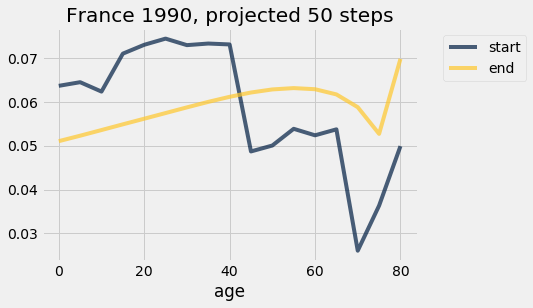

The plot shows the population distribution of French women in 1990 (in blue, labeled 'start') and the population distribution after projecting French women forward using the life table for 1990 French women for 50 time steps.

See if you can write a function that will produce a plot like this for any projection. Then compare the starting and ending age distributions across a few countries. How similar are they? Do you think that the starting age distribution affects the eventual stable age distribution?

In [ ]:
...
...
...

## Run all tests

This cell just re-runs all of the unit tests in the notebook, to summarize the results

In [ ]:
# this cell runs all the tests at once!
print("Running all tests...")
_ = [lab05.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('test')]
print("Finished running all tests.")

### Submit your assignment by MIDNIGHT on the day of class

Please submit your lab in by running the cell below. You can submit as many times as you want, up to midnight on the day of the class. No late submissions are allowed, and the system will prevent you from being able to submit late.

In [ ]:
_ = lab05.submit()